In [45]:
from os import system
import pandas as pd
import numpy as np
import time
import copy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import graphviz
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score

In [46]:
data1 = pd.read_csv('flight_3.csv')
data1 = data1.drop(['yaw', 'Cost'],axis=1)
N_B1 = np.sum(data1["controller_ID"] == "Backstepping_1")
N_B2 = np.sum(data1["controller_ID"] == "Backstepping_2")
N_B3 = np.sum(data1["controller_ID"] == "Backstepping_3")
N_B4 = np.sum(data1["controller_ID"] == "Backstepping_4")


print(N_B1)
print(N_B2)
print(N_B3)
print(N_B4)
data1[0:10]

117
111
109
259


,pos_diffx,pos_diffy,pos_diffz,vel_desx,vel_desy,vel_desz,acc_desx,acc_desy,acc_desz,velx,vely,velz,accx,accy,accz,roll,pitch,Tf,controller_ID
0,-3.406124,-0.463279,-3.843219,-0.556558,0.517774,0.368955,0.156461,0.228970,-0.216002,-0.210530,0.213225,-0.062273,0.038911,-0.093202,0.028981,0.071683,-0.032652,8.366503,Backstepping_4
1,-5.568677,2.678353,1.346688,0.283904,-0.867517,0.108960,-0.259487,0.201390,-0.047194,0.217750,-0.001168,0.137095,-0.035548,0.093089,0.011258,-0.052900,-0.097791,8.032831,Backstepping_4
2,3.482327,8.706492,-1.290032,-0.171118,0.957956,-0.393306,0.268893,-0.125870,0.039919,0.021469,0.136070,0.102724,0.043603,-0.015940,0.086005,-0.082615,0.098968,9.372240,Backstepping_4
3,-7.419759,-4.515988,5.229926,0.128294,0.402451,-0.743469,-0.020257,0.149499,-0.176238,0.229326,0.208189,-0.080184,-0.049539,0.043964,0.067757,0.080117,-0.023494,5.015985,Backstepping_2
4,-1.645906,-3.793227,-3.584632,-0.025293,-0.902433,0.149662,-0.036641,-0.261090,0.280851,0.025500,0.113455,0.033468,0.096924,0.020064,-0.017303,-0.051342,-0.045316,7.277134,Backstepping_1
5,-2.373539,7.309658,6.271077,-0.793769,0.832045,-0.839910,-0.237300,-0.019937,0.034693,-0.030565,-0.223095,-0.124856,0.055571,0.045418,0.049143,-0.095885,-0.009841,6.197021,Backstepping_1
6,7.001091,3.338282,5.785088,0.501501,-0.134853,-0.266331,-0.257527,0.065266,0.016682,0.115235,-0.067409,0.032067,0.084801,-0.053420,0.011683,-0.019156,0.089329,9.935677,Backstepping_4
7,5.009868,0.701681,4.121555,0.954883,0.630501,-0.727992,-0.066970,-0.067438,0.057571,0.197756,-0.029738,-0.109341,-0.030165,-0.087703,0.069581,-0.070663,-0.048274,7.027145,Backstepping_1
8,-2.242558,-2.863118,3.648658,-0.636643,0.379013,0.314545,-0.119097,-0.028669,0.012193,0.235018,0.130121,-0.051149,0.094957,-0.021524,-0.063277,-0.012538,-0.052621,9.507201,Backstepping_4
9,1.894733,6.259051,-0.374032,-0.614876,-0.027227,0.534950,0.079687,0.124803,0.124226,-0.090487,-0.156719,0.054091,-0.084566,-0.013723,0.023872,0.094544,0.025245,5.767569,Backstepping_4


In [35]:
X_train.shape

(446, 18)

In [33]:
N_Test = 100
dataset = data1.values
controller_labels = {'Backstepping_1': 0, 'Backstepping_2': 1, 'Backstepping_3': 2, 'Backstepping_4': 2}
y = np.array([controller_labels[data[-1]] for data in dataset]).reshape(-1,)
X = dataset[:,:-1]

X_test = X[0:N_Test,:]
y_test = y[0:N_Test]

X_train, X_val, y_train, y_val = train_test_split(X[N_Test:,:], y[N_Test:], test_size=0.1, random_state=42)

# Saving the objects:
# with open('dataset.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([X_train, X_val, X_test, y_train, y_val, y_test], f)
    
pickle.dump([X_train, X_val, X_test, y_train, y_val, y_test], open("dataset.pkl","wb"), protocol=2)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Decision Tree Design

Decision Tree Train Acc: 0.702, Val Acc: 0.42, Test Acc: 0.62
Random Forest Train Acc: 0.834, Val Acc: 0.52, Test Acc: 0.63


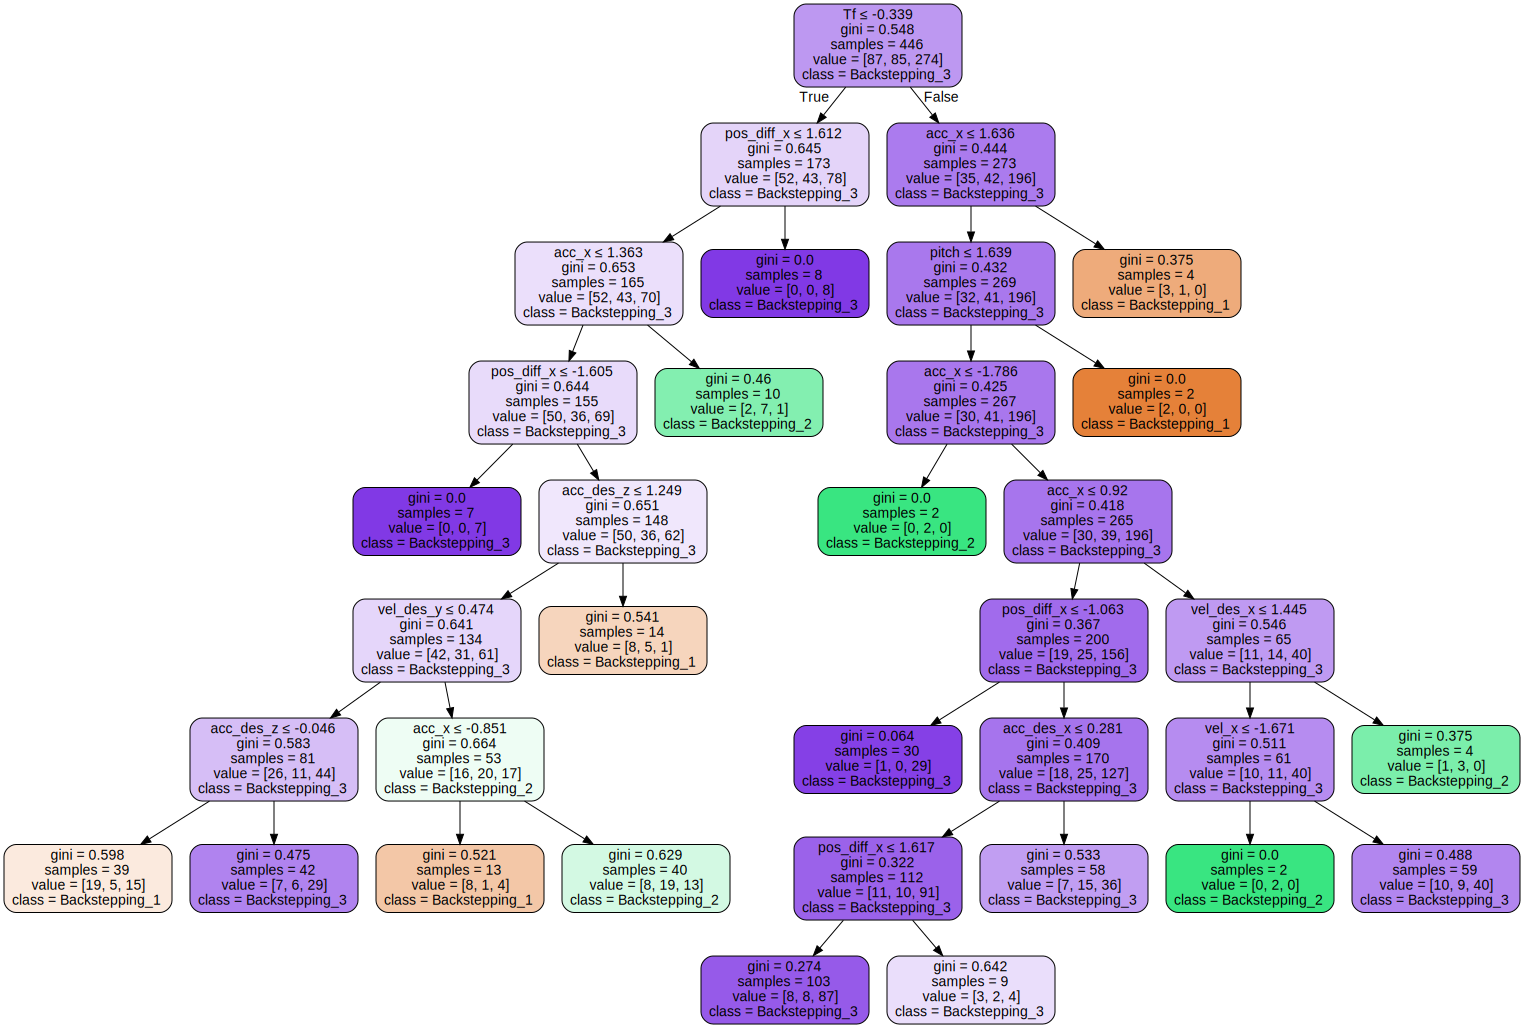

In [36]:
from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)


feature_names = ['pos_diff_x', 'pos_diff_x','pos_diff_x','vel_x','vel_x','vel_x','acc_x','acc_x','acc_x', 'roll', 'pitch', 'vel_des_x', 'vel_des_y', 'vel_des_z', 'acc_des_x', 'acc_des_y', 'acc_des_z', 'Tf']
class_names = ['Backstepping_1', 'Backstepping_2', 'Backstepping_3', 'Backstepping_4']
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
prune_index(clf.tree_, 0, 10)

train_pred = clf.predict(X_train)
val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)


train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

print ("Decision Tree Train Acc: {0:.3}, Val Acc: {1:.3}, Test Acc: {2:.3}".format(train_acc, val_acc, test_acc))


forest = RandomForestClassifier(bootstrap=True, n_estimators=100, 
                                min_samples_split=12, min_samples_leaf=5, max_features=10, max_depth=80)
forest = forest.fit(X_train, y_train)

train_pred = forest.predict(X_train)
val_pred = forest.predict(X_val)
test_pred = forest.predict(X_test)


train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

print ("Random Forest Train Acc: {0:.3}, Val Acc: {1:.3}, Test Acc: {2:.3}".format(train_acc, val_acc, test_acc))

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data) 
graph

# Neural Network Design

In [41]:
def predict(X, y, model):
    #Validation part
    model.eval()  # Set model to training mode

    inputs, labels = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device).long()

    outputs = model(inputs.float())
    _, preds = torch.max(outputs, 1)

    loss = criterion(outputs, labels)
    
    accuracy = torch.sum(preds == labels.data).item() / float(inputs.size(0))
    
    print ("Test data, Loss: {0:.3}, Accuracy: {1:.4}".format(loss.item(), accuracy))
    

def shuffle_dataset(X, y):
    p = np.random.permutation(len(X))
    return X[p], y[p]

def train_model(X, y, X_val, y_val, model, criterion, optimizer, scheduler, minibatch_size, num_epochs=25):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    losses_train = []
    losses_val = []
    accuracy_train = []
    accuracy_val = []
    # path = F"/content/drive/My Drive/best_model.pt"
#     directory = path_name

#     if not os.path.exists(directory):
#         os.makedirs(directory)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        X_train, y_train = shuffle_dataset(X, y)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        losses_iter = []
        accuracy_iter = []

        # Iterate over data.
        for i in range(0, X_train.shape[0], minibatch_size):
            # Get pair of (X, y) of the current minibatch/chunk             
            X_batch = X_train[i:i + minibatch_size]
            y_batch = y_train[i:i + minibatch_size]

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = torch.from_numpy(X_batch).to(device), torch.from_numpy(y_batch).to(device).long()


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs.float())
                _, preds = torch.max(outputs, 1)
                
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
            
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # print ("losses_iter", loss.item() * inputs.size(0))
            # print ("accuracy_iter", torch.sum(preds == labels.data).item() / float(inputs.size(0)))

            losses_iter.append(loss.item())
            accuracy_iter.append(torch.sum(preds == labels.data).item() / float(inputs.size(0)))
        
            scheduler.step()
        
        train_loss = np.mean(losses_iter)
        train_acc = np.mean(accuracy_iter)

        losses_train.append(train_loss)
        accuracy_train.append(train_acc)


        print('Training Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))
        
        #Validation part
        model.eval()  # Set model to training mode
        
        inputs, labels = torch.from_numpy(X_val).to(device), torch.from_numpy(y_val).to(device).long()
        
        optimizer.zero_grad()
        
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        
        val_loss = loss.item()
        val_acc = torch.sum(preds == labels.data).item() / float(inputs.size(0))
        
        losses_val.append(val_loss)
        accuracy_val.append(val_acc)
        
        
        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))

#         deep copy the model
        if val_acc > best_acc:
            best_acc = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            path = "best_model.pt"
            torch.save(best_model_wts, path)

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}s'.format(time_elapsed))
    print('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop_layer = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(18, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc2(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc3(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc4(x))
        x = self.drop_layer(x)
        x = self.fc5(x)
        return x

n_epochs = 100
minibatch_size = 32
learning_rate = 0.001
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, X_train.shape[0], eta_min=learning_rate)
final_mode = train_model(X_train, y_train, X_val, y_val, model, criterion, optimizer, scheduler, minibatch_size, num_epochs=n_epochs)

Epoch 0/99
----------
Training Loss: 1.3199 Acc: 0.4583
Validation Loss: 1.2165 Acc: 0.5400

Epoch 1/99
----------
Training Loss: 1.0901 Acc: 0.6104
Validation Loss: 1.1221 Acc: 0.5400

Epoch 2/99
----------
Training Loss: 1.0107 Acc: 0.6092
Validation Loss: 1.0573 Acc: 0.5400

Epoch 3/99
----------
Training Loss: 0.9433 Acc: 0.6149
Validation Loss: 1.0657 Acc: 0.5400

Epoch 4/99
----------
Training Loss: 0.9586 Acc: 0.6147
Validation Loss: 1.0516 Acc: 0.5400

Epoch 5/99
----------
Training Loss: 0.9358 Acc: 0.6121
Validation Loss: 1.0659 Acc: 0.5400

Epoch 6/99
----------
Training Loss: 0.9307 Acc: 0.6118
Validation Loss: 1.0767 Acc: 0.5400

Epoch 7/99
----------
Training Loss: 0.9537 Acc: 0.6012
Validation Loss: 1.0587 Acc: 0.5400

Epoch 8/99
----------
Training Loss: 0.9125 Acc: 0.6103
Validation Loss: 1.1117 Acc: 0.5400

Epoch 9/99
----------
Training Loss: 0.9150 Acc: 0.6122
Validation Loss: 1.0650 Acc: 0.5400

Epoch 10/99
----------
Training Loss: 0.8958 Acc: 0.6140
Validation Lo

Training Loss: 0.3239 Acc: 0.8882
Validation Loss: 3.0154 Acc: 0.4600

Epoch 90/99
----------
Training Loss: 0.3165 Acc: 0.8902
Validation Loss: 3.0936 Acc: 0.4400

Epoch 91/99
----------
Training Loss: 0.2984 Acc: 0.8970
Validation Loss: 3.2416 Acc: 0.4600

Epoch 92/99
----------
Training Loss: 0.3253 Acc: 0.8946
Validation Loss: 3.2752 Acc: 0.4600

Epoch 93/99
----------
Training Loss: 0.2959 Acc: 0.8899
Validation Loss: 3.8218 Acc: 0.4200

Epoch 94/99
----------
Training Loss: 0.3059 Acc: 0.8990
Validation Loss: 3.6857 Acc: 0.4600

Epoch 95/99
----------
Training Loss: 0.2788 Acc: 0.9106
Validation Loss: 3.6249 Acc: 0.5000

Epoch 96/99
----------
Training Loss: 0.2664 Acc: 0.8949
Validation Loss: 3.5113 Acc: 0.5000

Epoch 97/99
----------
Training Loss: 0.2256 Acc: 0.9326
Validation Loss: 3.5701 Acc: 0.4800

Epoch 98/99
----------
Training Loss: 0.2696 Acc: 0.8964
Validation Loss: 3.8275 Acc: 0.4400

Epoch 99/99
----------
Training Loss: 0.3497 Acc: 0.8768
Validation Loss: 3.3087 Ac

In [43]:
predict(X_test, y_test, model)

Test data, Loss: 0.89, Accuracy: 0.67


# SVM

In [40]:
svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

svc = svc.fit(X_train, y_train)

train_pred = svc.predict(X_train)
val_pred = svc.predict(X_val)
test_pred = svc.predict(X_test)


train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

print ("SVM Train Acc: {0:.3}, Val Acc: {1:.3}, Test Acc: {2:.3}".format(train_acc, val_acc, test_acc))

SVM Train Acc: 0.641, Val Acc: 0.54, Test Acc: 0.67
